In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

In [2]:
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tifffile as tiff
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
from skimage import io
#import curve_fit 
from scipy.optimize import curve_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
#import convexhull
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
import pickle

In [3]:
SAVE = False

In [4]:
#utility function to create the parameter dics

def utility_params(initial_dict,num_tracks,mean_track_length,density_dif,track_distribution,psf):
    initial_dict = initial_dict
    cell_parms = {
        "diffusion_coefficients":np.array(list(0.45*np.ones(num_tracks))),
        "initials": initial_dict,
        "num_tracks":num_tracks,
        "track_type":"constant",
        "hursts":np.array(list(0.2*np.ones(num_tracks))),
        "dims":(200,200),
        "movie_frames":500,
        "cell_space":np.array([80,120,90,105])
    }     
    global_sim_params = {
        "track_length_mean":mean_track_length,
        "track_distribution":track_distribution,
        "exposure_time":20,#ms same as frame_time
        "base_noise":140,
        "point_intensity":20,
        "psf_sigma":psf,
        "frame_time":20,#ms
        "pixel_size":130,
        "axial_function":"exponential",
        "density_dif": density_dif
    }
    return initial_dict,cell_parms,global_sim_params
#lets make a utility function to perform the scale-space
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 500, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c

#define a utility function to detect the true positives and the error in the centers and scale
def true_positive_and_erros(true_clusters,found_clusters,center_threshold=0.5):
    '''true clusters is the initial_dict, the found is the scale space output from the blob detection'''
    #get the true centers and scale
    true_centers = true_clusters["initial_centers"]
    true_scale = true_clusters["initial_scale"]
    #get the found centers and scale
    found_centers = np.array([found_clusters["Fitted"][i][:2] for i in range(len(found_clusters["Fitted"]))])

    found_scale = np.array([np.mean([found_clusters["Fitted"][i][2],found_clusters["Fitted"][i][3]]) for i in range(len(found_clusters["Fitted"]))])
    #get the true positives
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan
    for i in range(len(true_centers)):
        for j in range(len(found_centers)):
            if np.linalg.norm(true_centers[i]-found_centers[j][::-1])<center_threshold:
                if true_center_TP_center_error[i] > np.linalg.norm(true_centers[i]-found_centers[j][::-1]) or np.isnan(true_center_TP_center_error[i]):
                    true_center_TP_center_error[i] = np.linalg.norm(true_centers[i]-found_centers[j][::-1])
                    true_center_TP_scale_error[i] = np.abs(true_scale[i]-found_scale[j])/true_scale[i]

    #get the false positives
    #this is just the total number of found centers minus the true positives (len of the true_center_TP_center_error without the nans)
    false_positives = len(found_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])

    
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error

#lets make a utility function to create all points in the cell using the points per frame dict
def create_all_points(points_per_frame_dict):
    all_points = []
    for frame in points_per_frame_dict.keys():
        #only take the x,y coordinates
        if len(points_per_frame_dict[frame])>0:
            all_points.extend(np.array(points_per_frame_dict[frame])[:,0:2])
    return np.array(all_points)

#lets make a utility function to perform DBSCAN on the points per frame dict using supplied parameters D and minPts.
def perform_DBSCAN(points_per_frame_dict,D,minPts,convert=False):
    if convert == True:
        all_points = create_all_points(points_per_frame_dict)
    else:
        all_points = points_per_frame_dict
    db = DBSCAN(eps=D, min_samples=minPts).fit(all_points)
    labels = db.labels_
    return labels

#make a utility function for DBSCAN TP and FP and center and scale errors
def DBSCAN_TP_FP_center_scale_error(ID_dict,points_per_frame,D,minPts,convert=False,threshold=1.):
    #convert the points_perf_frame dict to a list of points
    if convert == True:
        all_points = create_all_points(points_per_frame)
    else:
        all_points = points_per_frame
    #perform DBSCAN
    labels = perform_DBSCAN(all_points,D,minPts,convert=False)
    #number of clusters
    num_clusters = len(np.unique(labels))-1

    cluster_scales = []
    cluster_centers = []
    for cluster in np.unique(labels):
        if cluster != -1:
            circle_made = smallestenclosingcircle.make_circle(points_per_frame[labels==cluster])
            cluster_scales.append(circle_made[2])
            cluster_centers.append(circle_made[0:2])
    cluster_scales = np.array(cluster_scales)
    cluster_centers = np.array(cluster_centers)
    #lets get the true positives and errors
    #find the true centers and scales
    true_centers = np.array(ID_dict["initial_centers"])
    true_scale = np.array(ID_dict["initial_scale"])
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan

    if num_clusters > 0:
        for l in range(len(true_centers)):
            for m in range(len(cluster_centers)):
                if np.linalg.norm(true_centers[l]-cluster_centers[m])<threshold:
                    if true_center_TP_center_error[l] > np.linalg.norm(true_centers[l]-cluster_centers[m]) or np.isnan(true_center_TP_center_error[l]):
                        true_center_TP_center_error[l] = np.linalg.norm(true_centers[l]-cluster_centers[m])
                        true_center_TP_scale_error[l] = np.abs(true_scale[l]-cluster_scales[m])/true_scale[l]
    false_positives = len(cluster_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error

#make a utility function to perfrom the sim for the different threshold changes, track lengths and density dif
def perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,initial_dict_used,D_DBSCAN,minPts_DBSCAN):
    #make the collection of TP and FP and center and scale errors
    TP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    FP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    center_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))

    #lets contain the points per frame dict
    points_per_frame_collection = []
    #TP for the scale selection
    TP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    FP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    center_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    #lets contain the summed sim maps
    map_collection = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,200,200))

    for i in range(len(track_lengths)):
        for j in range(len(density_dif)):
            for k in range(repeats):
                #okay lets make the initial dict
                ID_sim, cell_parms_sim, global_sim_params_sim = utility_params(initial_dict_used,track_lengths[i],1,density_dif[j],"constant",1.)
                #lets simulate the data
                cell_sim = simulate_cells.Simulate_cells(cell_parms_sim,global_sim_params_sim)
                a_sim = cell_sim.get_cell()
                
                #store the points per frame dict
                points_per_frame_collection.append(a_sim["points_per_frame"])
                #store the summed map
                map_collection[i,j,k,:,:] = np.sum(a_sim["map"],axis=0)

                #lets get the points per frame dict
                points_per_frame_dict = create_all_points(a_sim["points_per_frame"])
                #lets perform DBSCAN using the utility function
                DBSCAN_TP,DBSCAN_FP,DBSCAN_center_error,DBSCAN_scale_error = DBSCAN_TP_FP_center_scale_error(ID_sim,points_per_frame_dict,D_DBSCAN,minPts_DBSCAN,convert=False)
                #lets update the collection
                TP_collection_DB[i,j,k] = DBSCAN_TP
                FP_collection_DB[i,j,k] = DBSCAN_FP
                center_error_collection_DB[i,j,k,:] = DBSCAN_center_error
                scale_error_collection_DB[i,j,k,:] = DBSCAN_scale_error

                #lets perform scale selection on the simulated data
                for l in range(len(threshold_changes)):
                    c_sim_LD = scale_utility(img_map = np.sum(a_sim["map"],axis=0),threshold = threshold_changes[l])
                    #lets get the true positives and errors
                    true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_sim,c_sim_LD,center_threshold=1)
                    #lets update the collection
                    TP_collection_scale[i,j,l,k] = true_positive_num
                    FP_collection_scale[i,j,l,k] = false_positives
                    center_error_collection_scale[i,j,l,k,:] = true_center_TP_center_error
                    scale_error_collection_scale[i,j,l,k,:] = true_center_TP_scale_error
                #print updates
                print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)
    #make a collection of the TP and FP and center and scale errors for DBSCAN and scale selection
    DBSCAN_collection = [TP_collection_DB,FP_collection_DB,center_error_collection_DB,scale_error_collection_DB]
    scale_collection = [TP_collection_scale,FP_collection_scale,center_error_collection_scale,scale_error_collection_scale]
    return DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection
 
#make a utility function to perfrom the sim for the different threshold changes, track lengths and density dif
def perform_sim_for_diff_thresholds_plus_sim_cells(track_lengths,density_dif,threshold_changes,repeats,initial_dict_used,D_DBSCAN,minPts_DBSCAN):
    #make the collection of TP and FP and center and scale errors
    TP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    FP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    center_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))

    #lets contain the points per frame dict
    points_per_frame_collection = []
    #TP for the scale selection
    TP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    FP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    center_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    #lets contain the summed sim maps
    map_collection = np.zeros((len(track_lengths),len(density_dif),repeats,200,200))

    for i in range(len(track_lengths)):
        for j in range(len(density_dif)):
            for k in range(repeats):
                #okay lets make the initial dict
                ID_sim, cell_parms_sim, global_sim_params_sim = utility_params(initial_dict_used,track_lengths[i],1,density_dif[j],"constant",1.)
                #lets simulate the data
                cell_sim = simulate_cells.Simulate_cells(cell_parms_sim,global_sim_params_sim)
                a_sim = cell_sim.get_cell()
                
                #store the points per frame dict
                points_per_frame_collection.append(a_sim["points_per_frame"])
                #store the summed map
                map_collection[i,j,k] = np.sum(a_sim["map"],axis=0)

                #lets get the points per frame dict
                points_per_frame_dict = create_all_points(a_sim["points_per_frame"])
                #lets perform DBSCAN using the utility function
                DBSCAN_TP,DBSCAN_FP,DBSCAN_center_error,DBSCAN_scale_error = DBSCAN_TP_FP_center_scale_error(ID_sim,points_per_frame_dict,D_DBSCAN,minPts_DBSCAN,convert=False)
                #lets update the collection
                TP_collection_DB[i,j,k] = DBSCAN_TP
                FP_collection_DB[i,j,k] = DBSCAN_FP
                center_error_collection_DB[i,j,k] = DBSCAN_center_error
                scale_error_collection_DB[i,j,k] = DBSCAN_scale_error

                #lets perform scale selection on the simulated data
                for l in range(len(threshold_changes)):
                    c_sim_LD = scale_utility(img_map = np.sum(a_sim["map"],axis=0),threshold = threshold_changes[l])
                    #lets get the true positives and errors
                    true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_sim,c_sim_LD,center_threshold=1)
                    #lets update the collection
                    TP_collection_scale[i,j,l,k] = true_positive_num
                    FP_collection_scale[i,j,l,k] = false_positives
                    center_error_collection_scale[i,j,l,k] = true_center_TP_center_error
                    scale_error_collection_scale[i,j,l,k] = true_center_TP_scale_error
                #print updates
                print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)
    #make a collection of the TP and FP and center and scale errors for DBSCAN and scale selection
    DBSCAN_collection = [TP_collection_DB,FP_collection_DB,center_error_collection_DB,scale_error_collection_DB]
    scale_collection = [TP_collection_scale,FP_collection_scale,center_error_collection_scale,scale_error_collection_scale]
    return DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection

#utility function to make the initial dicts for various sizes
def utility_condensate_size_initial_dict(sizes,diffusion_coefficient,hurst_exponent):
    initial_dict_collection = []
    for i in range(len(sizes)):
        initial_dict = {
        "initial_centers":np.array([[100,95]]),
        "initial_scale": np.array([sizes[i]]),
        "diffusion_coefficient": np.array([diffusion_coefficient]),
        "hurst_exponent": np.array([hurst_exponent])  
        }
        initial_dict_collection.append(initial_dict)
    return initial_dict_collection

In [5]:
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/dense_sampled/diffusion_001/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_dense_001 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/dense_sampled/diffusion_01/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_dense_01 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/dense_sampled/diffusion_1/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_dense_1 = pickle.load(f)

In [6]:
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/sparce_sampled/diffusion_001/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_sparce_001 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/sparce_sampled/diffusion_01/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_sparce_01 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/sparce_sampled/diffusion_1/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_sparce_1 = pickle.load(f)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-08-16 12:27:08.364727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 12:27:08.365192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_001/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_upper_001 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_01/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_upper_01 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_1/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_upper_1 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_0/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_upper_0 = pickle.load(f)
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_0001/collection_sizes_sim_results.pkl','rb') as f:
    collection_sizes_sim_results_upper_0001 = pickle.load(f)

In [8]:
#load the param file
with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_5/upper_sample/diffusion_001/collection_sizes_sim_params.pkl', 'rb') as f:
    param_file = pickle.load(f)

In [29]:
#utility function to reformat data from cluster sizes -> locs. to locs -> cluster sizes for efficient plotting

def utility_size_loc_convert(data,params,which="Scale"):
    track_lengths,density_dif,repeats,threshold_range,D_DBSCAN,minP_DBSCAN,sizes_condensates,diffusion_coefficient_1,hurst_035,initial_dict_collection_sizes = params
    loc_size_means_scale_error = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_stds_scale_error = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_means_TP = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_stds_TP = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_means_FP = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_stds_FP = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_means_center_error = np.zeros((len(sizes_condensates),len(track_lengths)))
    loc_size_stds_center_error = np.zeros((len(sizes_condensates),len(track_lengths)))
    
    id_value = {"Scale":1,"DBSCAN":0}
    id = id_value[which]

    if which == "DBSCAN":
        for i in range(len(sizes_condensates)):
            loc_size_means_TP[i] = np.nanmean(data[i][0][id][0],axis=2).flatten()
            loc_size_stds_TP[i] = np.nanstd(data[i][0][id][0],axis=2).flatten()
            loc_size_means_FP[i] = np.nanmean(data[i][0][id][1],axis=2).flatten()
            loc_size_stds_FP[i] = np.nanstd(data[i][0][id][1],axis=2).flatten()

            loc_size_means_center_error[i] = np.nanmean(data[i][0][id][2],axis=2).flatten()
            loc_size_stds_center_error[i] = np.nanstd(data[i][0][id][2],axis=2).flatten()
            loc_size_means_scale_error[i] = np.nanmean(data[i][0][id][3],axis=2).flatten()
            loc_size_stds_scale_error[i] = np.nanstd(data[i][0][id][3],axis=2).flatten()
    else:
        for i in range(len(sizes_condensates)):
            loc_size_means_TP[i] = np.nanmean(np.nanmean(data[i][0][id][0],axis=2),axis=2).flatten()
            loc_size_stds_TP[i] = np.nanstd(np.nanmean(data[i][0][id][0],axis=2),axis=2).flatten()
            loc_size_means_FP[i] = np.nanmean(np.nanmean(data[i][0][id][1],axis=2),axis=2).flatten()
            loc_size_stds_FP[i] = np.nanstd(np.nanmean(data[i][0][id][1],axis=2),axis=2).flatten()

            loc_size_means_center_error[i] = np.nanmean(np.nanmean(data[i][0][id][2],axis=2),axis=2).flatten()
            loc_size_stds_center_error[i] = np.nanstd(np.nanmean(data[i][0][id][2],axis=2),axis=2).flatten()
            loc_size_means_scale_error[i] = np.nanmean(np.nanmean(data[i][0][id][3],axis=2),axis=2).flatten()
            loc_size_stds_scale_error[i] = np.nanstd(np.nanmean(data[i][0][id][3],axis=2),axis=2).flatten()
    
    #return the transpose of each of the arrays
    return_data = [loc_size_means_TP.T,loc_size_stds_TP.T,loc_size_means_FP.T,loc_size_stds_FP.T,loc_size_means_center_error.T,loc_size_stds_center_error.T,loc_size_means_scale_error.T,loc_size_stds_scale_error.T]
    return return_data

#test the function on collection_sizes_sim_results_dense_001
test = utility_size_loc_convert(collection_sizes_sim_results_upper_001,param_file,"Scale")

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_29006/412707594.py:35: RuntimeWarning: Mean of empty slice
  loc_size_means_center_error[i] = np.nanmean(np.nanmean(data[i][0][id][2],axis=2),axis=2).flatten()
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_29006/412707594.py:36: RuntimeWarning: Mean of empty slice
  loc_size_stds_center_error[i] = np.nanstd(np.nanmean(data[i][0][id][2],axis=2),axis=2).flatten()
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_29006/412707594.py:37: RuntimeWarning: Mean of empty slice
  loc_size_means_scale_error[i] = np.nanmean(np.nanmean(data[i][0][id][3],axis=2),axis=2).flatten()
/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_29006/412707594.py:38: RuntimeWarning: Mean of empty slice
  loc_size_std

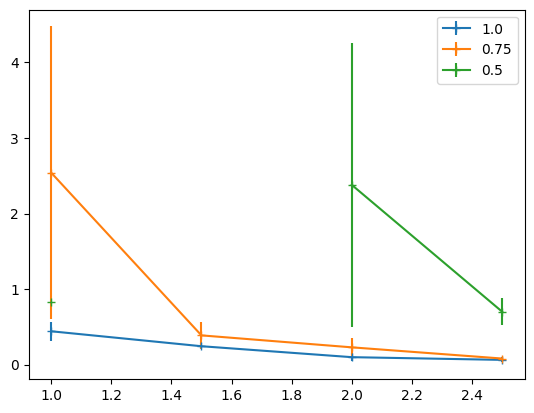

In [30]:
lens = param_file[0][::-1] #to account for the transpose
for i in range(len(test[0])):
    plt.errorbar(param_file[6],test[6][i], yerr=test[7][i], fmt='-+', label='{}'.format(lens[i]/4/500))
plt.legend()

{'Fitted': array([[ 95.09925028, 100.14772847,   2.62373907,   2.72765399],
        [143.31946289,  25.00127809,   0.45004719,   0.25055829],
        [ 39.69359242, 105.29588214,   1.15974535,   0.43449086]]),
 'Scale': array([[ 95.        , 100.        ,   2.64128257],
        [143.        ,  25.        ,   1.        ],
        [ 40.        , 105.        ,   1.        ]]),
 'Fit': [<lmfit.minimizer.MinimizerResult at 0x5ddf1a6e0>,
  <lmfit.minimizer.MinimizerResult at 0x5ddfcd630>]}

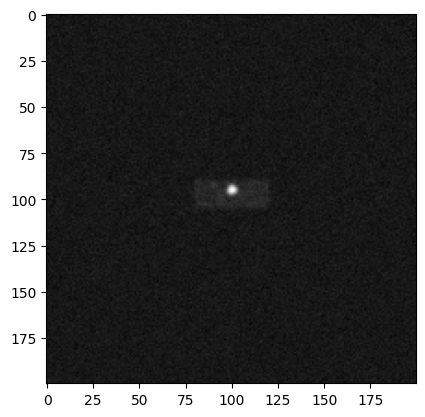

In [24]:
plt.imshow(collection_sizes_sim_results_upper_0[4][0][2][2][0][0],cmap = "gray")
scale_utility(collection_sizes_sim_results_upper_0[4][0][2][2][0][0],9.5e2)